# QRC + Classical Machine Learning methods

In this codebook, I build quantum circuits to create a quantum reservoir to map the stock price data into higher dimensions. Then I use classical regression models in order to predict the stock price accurately. 

In [28]:
# # # For Windows users since GPU based device config is unavailable for it
# !pip install pennylane

# # # For Linux users with GPUs
# # !pip install custatevec_cu12
# # !pip install pennylane-lightning-gpu

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install jax
# !pip install optax

# # # Library for NSE data
# !pip install openchart

In [29]:
from openchart import NSEData
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
import jax
from jax import numpy as jnp
import optax
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Data Engineering

In [30]:
# Downloading the NSE meta data.
nse=NSEData()
nse.download()

NSE data shape: (3189, 4)
NFO data shape: (85292, 4)
NSE and NFO data downloaded successfully.


In [31]:
# Downloading the data for Reliance from the NSE.

# The end date is the current timestamp and the start date is 30 days prior to that.
end_date=datetime.datetime.now()
start_date=end_date-datetime.timedelta(days=30)

# Extracting data for 1 minute intervals
data=nse.historical(
    start=start_date,
    end=end_date,
    symbol='RELIANCE',
    interval='1m',
    exchange='NSE'
)

# The extracted data is in ascending order of the timestamp, meaning the timestamp of the 1st row is from 30 days before the current date.
# Changing the dataframe to a descending order timestamp based dataframe.
# data=data.sort_index(ascending=False)

print(data.head(5))

                       Open    High     Low   Close  Volume
Timestamp                                                  
2025-11-06 09:15:59  1480.1  1490.9  1476.2  1489.9  323121
2025-11-06 09:16:59  1488.3  1491.0  1488.0  1488.1  145048
2025-11-06 09:17:59  1488.1  1488.3  1485.2  1485.5   59565
2025-11-06 09:18:59  1485.5  1488.8  1485.5  1488.8   41343
2025-11-06 09:19:59  1488.8  1491.6  1487.8  1490.2   45150


In [32]:
# Adding new features

data.columns=data.columns.str.lower()

trend=[]
open=data['open'].to_list()
close=data['close'].to_list()

for i in range(len(data)):
    if close[i]-open[i]>0:
        trend.append(1)
    else:
        trend.append(0)

data['trend']=trend

data['lag1']=data['close'].shift(1)
data['lag2']=data['close'].shift(2)

data["rolling_mean5"] = data["close"].rolling(5).mean()
data["rolling_std5"] = data["close"].rolling(5).std()

momentum=[]
for i in range(len(data)):
    if i+1==len(data):
        momentum.append(0)
    else:
        momentum.append(data.iloc[i][3]-data.iloc[i+1][3])

data['momentum']=momentum

data=data.dropna()

C:\Users\Srivats Ramaswamy\AppData\Local\Temp\ipykernel_25796\3100344807.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  momentum.append(data.iloc[i][3]-data.iloc[i+1][3])


In [33]:
data.head()

,open,high,low,close,volume,trend,lag1,lag2,rolling_mean5,rolling_std5,momentum
Timestamp,,,,,,,,,,,
2025-11-06 09:19:59,1488.8,1491.6,1487.8,1490.2,45150,1,1488.8,1485.5,1488.50,1.877498,-2.0
2025-11-06 09:20:59,1490.1,1492.2,1490.1,1492.2,62427,1,1490.2,1488.8,1488.96,2.488574,-2.8
2025-11-06 09:21:59,1492.6,1496.5,1492.6,1495.0,121977,1,1492.2,1490.2,1490.34,3.570434,0.6
2025-11-06 09:22:59,1494.6,1496.0,1494.1,1494.4,38388,0,1495.0,1492.2,1492.12,2.655560,0.1
2025-11-06 09:23:59,1494.3,1494.4,1492.5,1494.3,34870,0,1494.4,1495.0,1493.22,1.992988,0.5


In [34]:
print(len(data))

8085


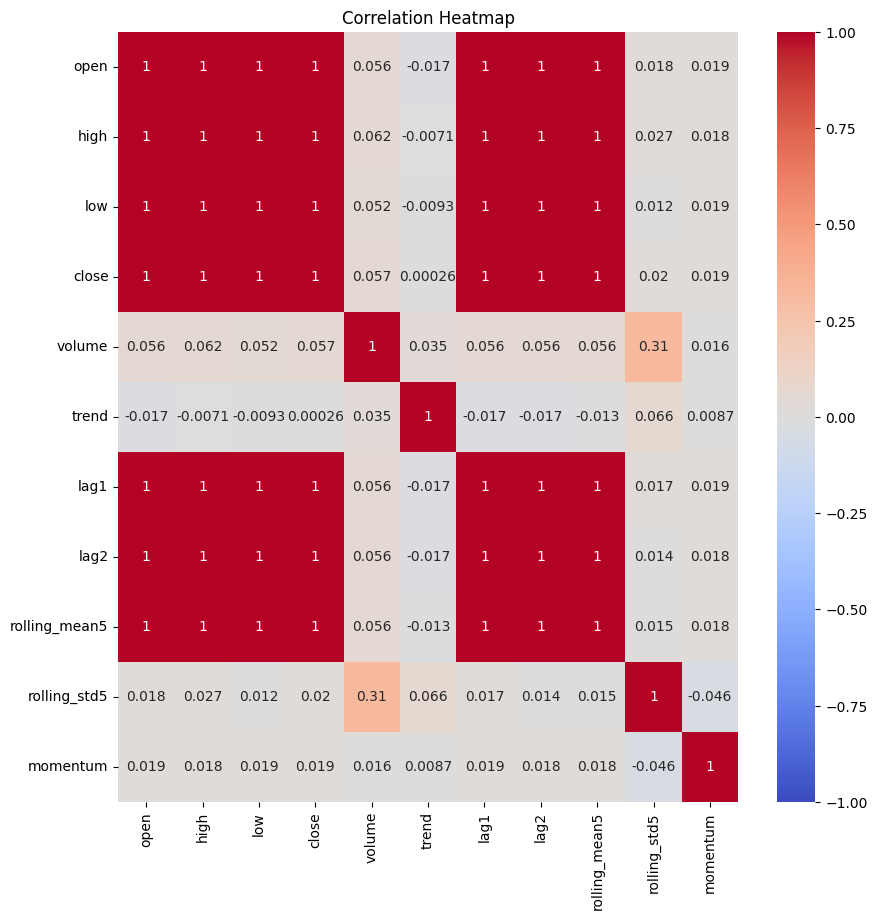

In [ ]:
# Plotting a correlation heatmap to see the correlation of all the features with each other. 
data.columns=data.columns.str.lower()
corr_matrix=data.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [36]:
# Creating a quantum reservior
# Adding non-linearity by converting the data into higher dimensional data
# Using angle encoding to get the data as quantum state probability amplitudes

reservoir_depth=5
qubits=4

device=qml.device('default.qubit',wires=qubits)

@qml.qnode(device=device)
def quantum_reservoir(data_point,theta_1,theta_2,wires=qubits,reservoir_depth=reservoir_depth,seed=42):
    pnp.random.seed(42)

    for i, value in enumerate(data_point):
        qml.Hadamard(wires=i)
        qml.RX(2*pnp.pi*value,wires=i)
        qml.RY(pnp.pi*value,wires=i)
        qml.RZ(3*pnp.pi*value,wires=i)

    for _ in range(reservoir_depth):

        for i in range(wires):
            qml.RY(pnp.random.uniform(0,pnp.pi),wires=i)

        for i in range(wires-1):
            qml.CNOT(wires=[i,i+1])

        for i in range(wires-2):
            qml.CRX(theta_1,wires=[i,i+1])
            qml.CRZ(theta_2,wires=[i+1,i+2])

    return qml.probs(wires=range(wires))

def extract_features(data,qubits,reservoir_depth):
    features=[]
    theta_1=pnp.pi/6
    theta_2=pnp.pi/4

    for data_point in data:
        exp_val=quantum_reservoir(data_point=data_point,theta_1=theta_1,theta_2=theta_2,wires=qubits,reservoir_depth=reservoir_depth)
        features.append(exp_val)

    return features


In [ ]:
# Using the following features in order to predict the closing price of the target variables. 
X=data[['lag1','lag2','rolling_mean5','rolling_std5']]
# X=data[['lag1']]
# X=data[['open','high','low','rolling_mean5']]

y=data['close']

# X=X.iloc[0:199]
# y=y.iloc[0:199]

# Splitting the data into training and testing data.
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8,random_state=42)

# Applying normalization to the data. 
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

# Converting the features into quantum feature data using a quantum reservoir.
# This will create 2^n features where n is the number of features before feeding the classical feature data into quantum reservoir. 
X_train_qrc=extract_features(X_train,qubits,reservoir_depth)
X_test_qrc=extract_features(X_test,qubits,reservoir_depth)


## Linear Regression

### Quantum Data

#### Training

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train_qrc, y_train)

print('QRC based train data results:')
preds = model.predict(X_train_qrc)
print("MSE:", str(mean_squared_error(y_train, preds)))
print("R²:", r2_score(y_train, preds))


QRC based train data results:
MSE: 641.3769549263485
R²: 0.08332952913861624


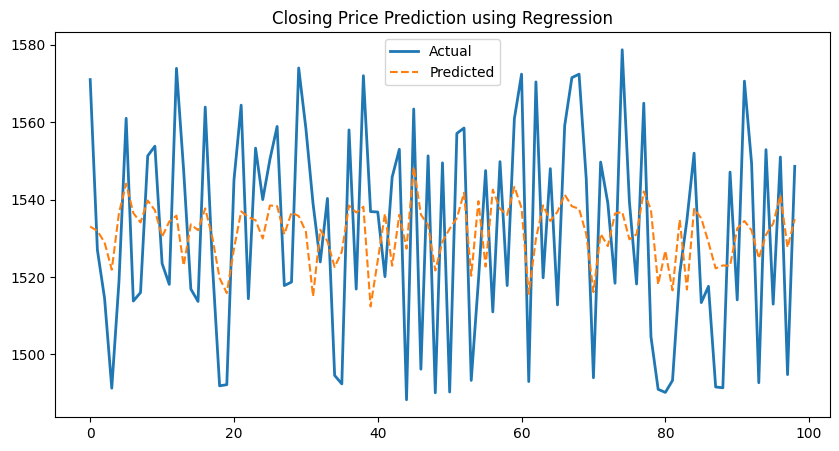

In [39]:
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression")
plt.show()

#### Testing

In [40]:
print('QRC based test data results:')
preds = model.predict(X_test_qrc)
print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))

QRC based test data results:
MSE: 657.9589138652211
R²: 0.07570430114533899


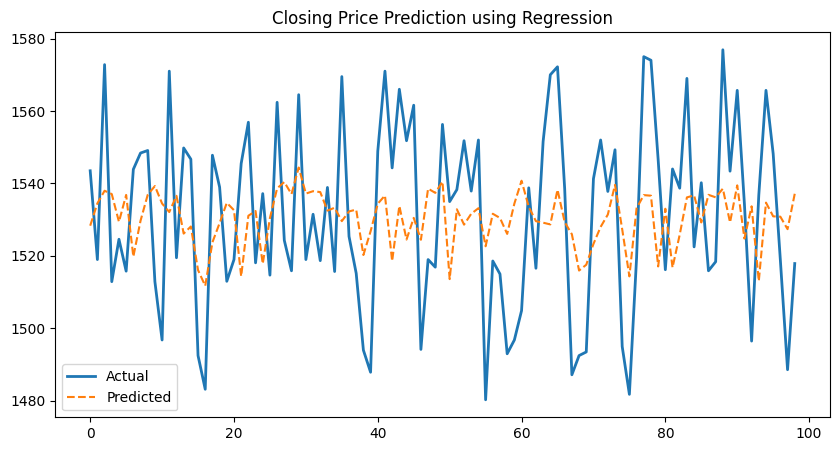

In [41]:
plt.figure(figsize=(10,5))
plt.plot(y_test[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression")
plt.show()


### Classical Data

#### Training

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)

print('Non-QRC based train data results:')
preds = model.predict(X_train)
print("MSE:", str(mean_squared_error(y_train, preds)))
print("R²:", r2_score(y_train, preds))


Non-QRC based train data results:
MSE: 0.46728153871659983
R²: 0.9993321506411633


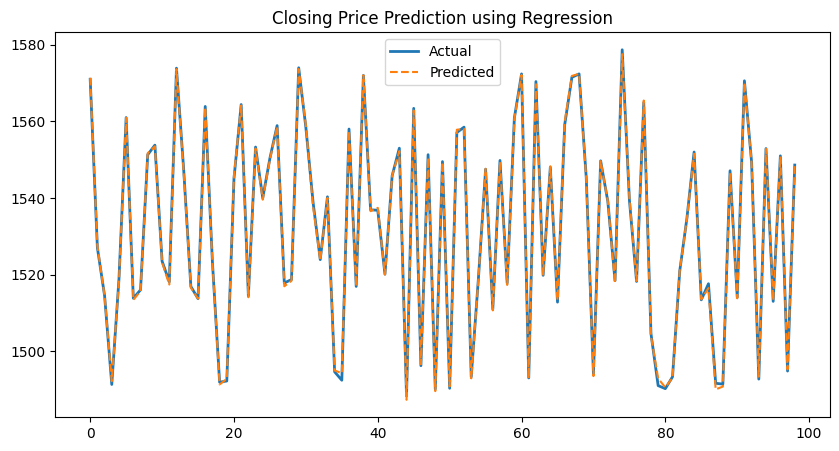

In [43]:
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression")
plt.show()

#### Testing

In [44]:
print('Non-QRC based test data results:')
preds = model.predict(X_test)
print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))

Non-QRC based test data results:
MSE: 0.4713631348711266
R²: 0.9993378326382105


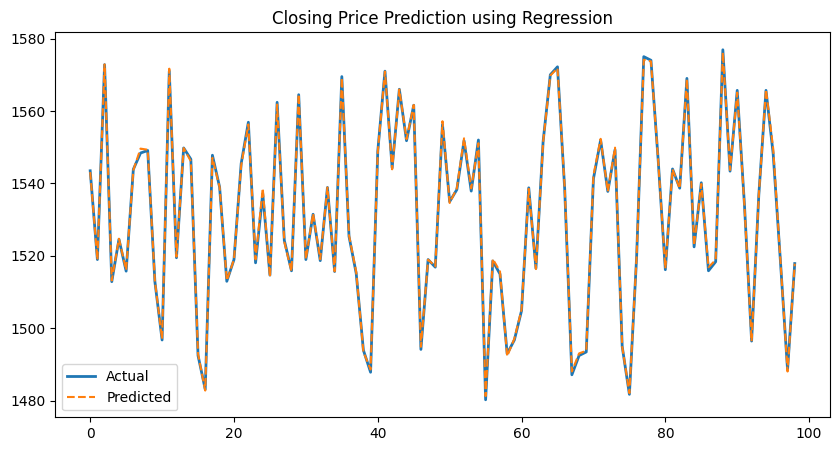

In [45]:
plt.figure(figsize=(10,5))
plt.plot(y_test[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression")
plt.show()


## Polynomial Regression

### Quantum Data

#### Training

In [46]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=4)
X_poly=poly.fit_transform(X_train_qrc)

model.fit(X_poly,y_train)
preds = model.predict(X_poly)

print("MSE:", str(mean_squared_error(y_train, preds)))
print("R²:", r2_score(y_train, preds))

MSE: 230.7712063323982
R²: 0.6701765650525111


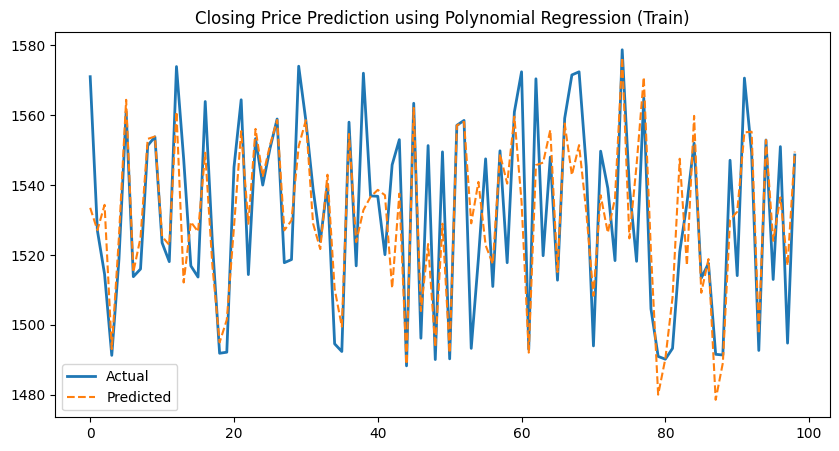

In [47]:
# Plot Qiskit testing data
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Polynomial Regression (Train)")
plt.show()

#### Testing

In [48]:
X_poly_test= poly.fit_transform(X_test_qrc)
preds = model.predict(X_poly_test)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))

MSE: 5442333.3266757615
R²: -7644.3486373926025


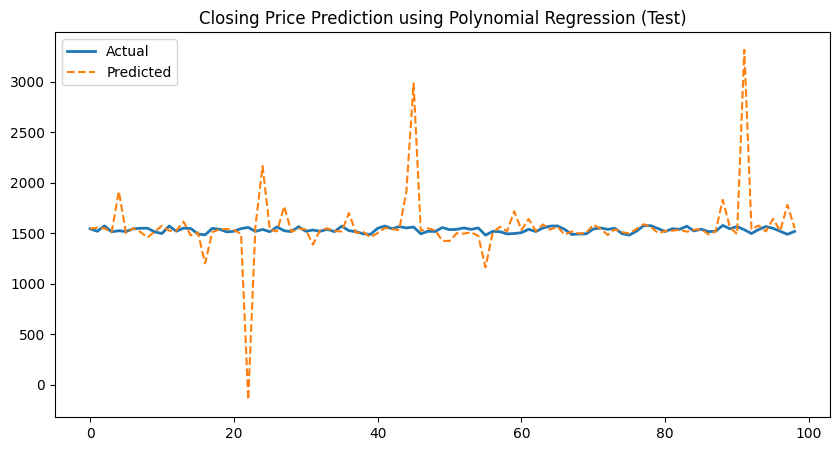

In [49]:
# Plot Qiskit testing data
plt.figure(figsize=(10,5))
plt.plot(y_test[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Polynomial Regression (Test)")
plt.show()

### Classical Data

#### Training

In [50]:
X_poly=poly.fit_transform(X_train)

model.fit(X_poly,y_train)
preds = model.predict(X_poly)

print("MSE:", str(mean_squared_error(y_train, preds)))
print("R²:", r2_score(y_train, preds))

MSE: 0.3449752140040023
R²: 0.9995069536106223


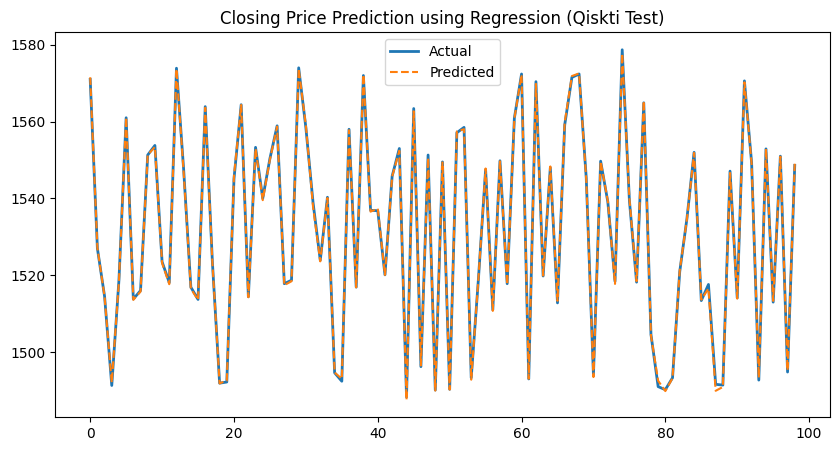

In [51]:
# Plot Qiskit testing data
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression (Qiskti Test)")
plt.show()

#### Testing

In [52]:
X_poly_test= poly.fit_transform(X_test)
preds = model.predict(X_poly_test)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))

MSE: 0.528150988106611
R²: 0.9992580574920932


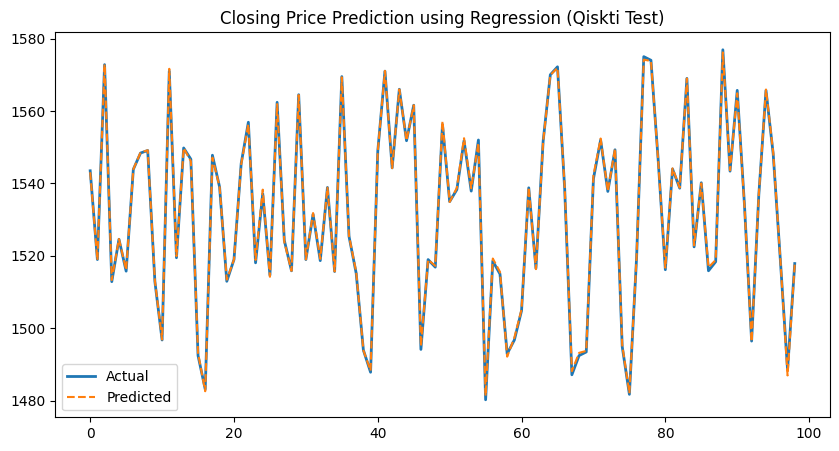

In [53]:
# Plot Qiskit testing data
plt.figure(figsize=(10,5))
plt.plot(y_test[0:99], label="Actual", linewidth=2)
plt.plot(preds[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("Closing Price Prediction using Regression (Qiskti Test)")
plt.show()